In [329]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
#Author: Selvaria
#keras分析期货值和平均油价联系

import pandas
import pymysql
import datetime
from dateutil.relativedelta import relativedelta

class FuturePredict(object):  # 针对时间和期货值的预测模型

    def __init__(self, code, o_type, month=2):
        #self.date = date
        #self.end_time = end_time
        self.code = code
        self.o_type = o_type
        self.month = month

    def get_futures_df(self):  # 获取对应编号的期货值dataframe，时间格式为字符串
        connection = pymysql.connect(host='47.92.25.70', user='root', password='Wfn031641', db='cxd_data',
                                     charset='utf8')
        sql = "select * from `oil_futures_daily` where `name` = '{}' ORDER BY `time_update` ASC".format(self.code)
        df = pandas.read_sql(sql, connection)
        connection.close()
        df['time_update'] = pandas.to_datetime(df['time_update'])
        for index in df.index:
            df.loc[index, 'time_update'] = df.loc[index, 'time_update'].strftime('%Y-%m-%d')
        df_sc = df[['name', 'close_val_yesd', 'time_update']]
        return df_sc

    def get_factory_df(self, end_time, copy=4):  # 获取油品价格数据，复制所需的份数，时间格式为字符串
        #datetime_now = datetime.datetime.now()
        #date_begin = end_time.strftime('%Y-%m-%d')[:-2]
        date_local = end_time[:-2]
        date_sql_start = date_local + '01'
        date_next = datetime.datetime.strptime(date_sql_start, '%Y-%m-%d') + relativedelta(months=1)
        date_sql_end = str(date_next)[:-2] + '01'
        connection = pymysql.connect(host='47.92.25.70', user='root', password='Wfn031641', db='cxd_data',
                                     charset='utf8')
        sql = "SELECT `type`,`date`,avg(`price`) FROM out_price_factory_value v JOIN out_price_factory_key k ON k.`id` \
                        = v.ref_key_id WHERE  `date` > '{0}' AND `date` < '{1}' AND `source_id` = '3' AND `type` like '{2}%' \
                        GROUP BY `date`".format(date_sql_start, date_sql_end, self.o_type)
        # print(sql)
        df_p = pandas.read_sql(sql, connection)
        connection.close()
        
        df_p2 = df_p.copy()
        for index in df_p2.index:
            df_p2.loc[index, 'date'] = df_p2.loc[index, 'date'] - relativedelta(months=copy-3)
        df_p3 = df_p.copy()
        for index in df_p3.index:
            df_p3.loc[index, 'date'] = df_p3.loc[index, 'date'] - relativedelta(months=copy-2)
        df_p4 = df_p.copy()    
        for index in df_p4.index:
            df_p4.loc[index, 'date'] = df_p4.loc[index, 'date'] - relativedelta(months=copy-1)
        df_middle1 = df_p4.append(df_p3, ignore_index=True)
        df_middle = df_middle1.append(df_p2, ignore_index=True)
        df_final = df_middle.append(df_p, ignore_index=True)
        
        #datetime_now = datetime.datetime.now()
        #date_begin = datetime.datetime.strptime(date_local+self.code[-2:], '%Y-%m-%d')
        date_begin = date_next
        for index in df_final.index:
            df_final.loc[index, 'date'] = df_final.loc[index, 'date'].strftime('%Y-%m-%d')
            df_final.loc[index, 'n_time'] = (date_begin - datetime.datetime.strptime(df_final.loc[index, 'date'], '%Y-%m-%d')).days            
        return df_final

    def df_handle(self, end_time):  # dataframe结构处理，合并有用的值，用于模型训练
        df_f = self.get_futures_df()
        df_f.rename(columns={'time_update': 'date'}, inplace=True)
        df_p = self.get_factory_df(end_time)
        df_result = pandas.merge(df_f, df_p, on='date', how='right')
        df_merge = df_result[df_result['close_val_yesd'] > 10]
        df_result = df_merge[df_merge['close_val_yesd'].notnull()]#[-60:]
        #length = len(df_result)
        #df_result.reindex(range(length))
        #df_use = df_result.copy()
        df_result['label'] = None
        for index in df_result.index:
            code = int(df_result.loc[index, 'name'][-4:])
            df_result.loc[index, 'name'] = float(code/100)
            try:
                change = df_result.loc[index, 'avg(`price`)'] - df_result.loc[index-1, 'avg(`price`)']
            except:
                change = 0
            df_result.loc[index, 'change'] = change
            #label_class = self.change_classify(change)
            label_class = self.change_classify_simple(change)
            df_result.loc[index, 'label'] = label_class
        df_use = df_result[['name','close_val_yesd','n_time','label']]
        #return df_result, df_use
        return df_use
    
    def change_classify_old(self, change):
        if change > -1 and change < 1:
            label = 0
        elif change >= 1 and change < 20:
            label = 10
        elif change >= 20 and change < 100:
            label = 50
        elif change >= 100:
            label = 100
        elif change <= -1 and change > -20:
            label = -10
        elif change <= -20 and change > -100:
            label = -50
        elif change <= -100:
            label = -100
        return label
    
    def change_classify(self, change):
        if change > -1 and change < 1:
            label = 0
        elif change >= 1 and change < 20:
            label = 1
        elif change >= 20 and change < 100:
            label = 2
        elif change >= 100:
            label = 3
        elif change <= -1 and change > -20:
            label = 4
        elif change <= -20 and change > -80:
            label = 5
        elif change <= -80:
            label = 6
        return label
    
    def change_classify_simple(self, change):
        if change > -5 and change < 5:
            label = 0
        elif change >= 5:
            label = 1
        elif change <= -5:
            label = 2
        return label
            
    
fp = FuturePredict('SC1812','0#国五')
df = fp.df_handle('2018-12-14')
#df = fp.get_factory_df('2018-12-14')
df

,name,close_val_yesd,n_time,label
0,18.12,521.2,120.0,0
1,18.12,523.9,119.0,0
2,18.12,521.3,118.0,1
3,18.12,520.0,117.0,2
4,18.12,516.8,116.0,2
5,18.12,524.5,113.0,1
6,18.12,524.3,112.0,2
7,18.12,535.9,111.0,2
8,18.12,533.3,110.0,0
9,18.12,525.8,109.0,0


In [330]:
def get_data_df(code, type_o, date):
    fp = FuturePredict(code, type_o)
    df = fp.df_handle(date)
    return df

df_1 = get_data_df('SC1807','0#国五','2018-07-14')
df_2 = get_data_df('SC1808','0#国五','2018-08-14')
df_3 = get_data_df('SC1809','0#国五','2018-09-14')
df_4 = get_data_df('SC1810','0#国五','2018-10-14')
df_5 = get_data_df('SC1811','0#国五','2018-11-14')
df_6 = get_data_df('SC1812','0#国五','2018-12-14')
df_7 = get_data_df('SC1901','0#国五','2019-01-14')
df_8 = get_data_df('SC1902','0#国五','2019-02-14')

df_test = get_data_df('SC1903','0#国五','2019-03-14')[-70:]

df_middle1 = df_1.append(df_2, ignore_index=True)
df_middle2 = df_middle1.append(df_3, ignore_index=True)
df_middle3 = df_middle2.append(df_4, ignore_index=True)
df_middle4 = df_middle3.append(df_5, ignore_index=True)
df_middle5 = df_middle4.append(df_6, ignore_index=True)
df_middle6 = df_middle5.append(df_7, ignore_index=True)
df_final = df_middle6.append(df_8, ignore_index=True)
df_final

,name,close_val_yesd,n_time,label
0,18.09,470.9,119.0,0
1,18.09,466.2,118.0,1
2,18.09,465.0,117.0,1
3,18.09,465.8,116.0,0
4,18.09,468.3,115.0,0
5,18.09,467.5,112.0,1
6,18.09,472.1,111.0,1
7,18.09,464.5,110.0,1
8,18.09,468.1,109.0,0
9,18.09,467.2,108.0,2


In [294]:
s = df_final.loc[0, 'name']
print(type(s))

<class 'float'>


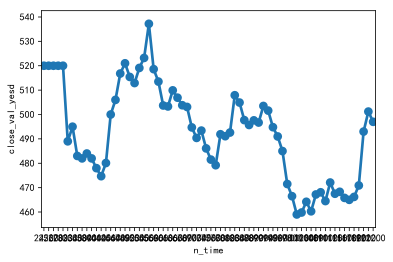

In [279]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

sns.pointplot(x='n_time', y='close_val_yesd',data=df_final[:70])
#sns.countplot(df_test['label'])

In [296]:
df_test

,name,close_val_yesd,n_time,label
1,19.03,432.0,118.0,5
2,19.03,439.2,117.0,2
3,19.03,438.9,116.0,5
4,19.03,438.2,115.0,5
5,19.03,424.3,114.0,4
6,19.03,424.3,112.0,5
7,19.03,438.7,111.0,2
8,19.03,431.6,110.0,2
9,19.03,432.4,109.0,2
10,19.03,431.0,108.0,0


In [347]:
#标准化及选取数据集和验证集

train_data = df_final[['name', 'close_val_yesd', 'n_time']]
train_label = df_final['label'].values

test_data = df_test[['name', 'close_val_yesd', 'n_time']]
test_label = df_test['label'].values

mean = train_data.mean()
train_data -= mean
std = train_data.std()
train_data /= std

test_data -= mean
test_data /= std

train_data = train_data.values
test_data = test_data.values
train_data

array([[-0.7389043332287415, -0.40012802198718456, 1.6618419105810607],
       [-0.7389043332287415, -0.492677988209076, 1.6275129399204828],
       [-0.7389043332287415, -0.5163077668189204, 1.593183969259905],
       ...,
       [1.4239426944672635, -1.000718228320737, -1.8397130967978783],
       [1.4239426944672635, -1.000718228320737, -1.8740420674584561],
       [1.4239426944672635, -0.9770884497108915, -1.908371038119034]],
      dtype=object)

In [295]:
#标准化及选取数据集和验证集

train_data = df_final[['name', 'close_val_yesd', 'n_time']].values
train_label = df_final['label'].values

test_data = df_test[['name', 'close_val_yesd', 'n_time']].values
test_label = df_test['label'].values

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

train_data

AttributeError: 'float' object has no attribute 'sqrt'

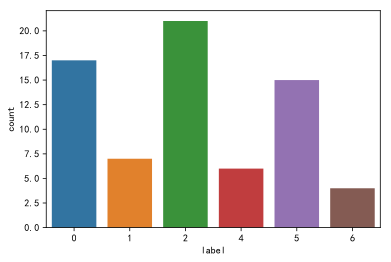

In [221]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#sns.countplot(df_final['label'])
sns.countplot(df_test['label'])

In [83]:
train_label = train_label.astype(int)

In [113]:
print(len(train_label))
train_label

210


array([0., 1., 0., 4., 4., 2., 4., 4., 5., 4., 0., 0., 4., 5., 5., 1., 2.,
       4., 2., 2., 1., 4., 4., 1., 1., 0., 2., 4., 4., 4., 4., 5., 1., 0.,
       0., 4., 6., 2., 5., 1., 4., 2., 1., 4., 1., 4., 1., 4., 4., 2., 4.,
       5., 4., 0., 1., 4., 1., 4., 0., 1., 0., 4., 4., 2., 5., 5., 4., 1.,
       0., 5., 0., 6., 5., 5., 5., 5., 5., 5., 4., 4., 4., 3., 4., 1., 4.,
       4., 5., 0., 4., 4., 5., 6., 5., 1., 4., 5., 6., 5., 4., 4., 3., 0.,
       4., 4., 5., 4., 6., 5., 1., 4., 5., 5., 5., 5., 4., 5., 4., 6., 3.,
       4., 4., 5., 4., 5., 4., 4., 5., 4., 4., 6., 5., 4., 5., 5., 5., 6.,
       4., 4., 4., 4., 0., 1., 4., 5., 4., 0., 1., 3., 4., 4., 5., 1., 5.,
       0., 4., 1., 5., 4., 5., 0., 6., 6., 0., 2., 3., 4., 4., 1., 4., 1.,
       5., 1., 1., 5., 1., 5., 4., 1., 4., 1., 5., 5., 0., 1., 6., 6., 0.,
       2., 3., 0., 1., 4., 4., 1., 0., 4., 4., 1., 1., 5., 4., 0., 4., 1.,
       4., 5., 4., 4., 0., 1.])

In [87]:
import numpy as np

def to_one_hot(labels, dimension=7):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

one_hot_train_label = to_one_hot(train_label)
one_hot_test_label = to_one_hot(test_label)

IndexError: index 10 is out of bounds for axis 1 with size 7

In [332]:
from keras.utils.np_utils import to_categorical

one_hot_train_label = to_categorical(train_label)
one_hot_test_label = to_categorical(test_label)

In [304]:
len(one_hot_test_label[0])

7

In [349]:
#建模(全连接层)

from keras import models
from keras.layers import Dense, Dropout

model = models.Sequential()
model.add(Dense(32, activation='relu', input_shape=(train_data.shape[1],)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.1))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_data, one_hot_train_label,
    epochs = 10,
    batch_size = 16,
    validation_data = (test_data, one_hot_test_label)
)

#results = model.evaluate()

Train on 408 samples, validate on 70 samples
Epoch 1/10
408/408 [==============================] - 4s 11ms/step - loss: 1.0991 - acc: 0.4118 - val_loss: 1.1050 - val_acc: 0.3571
Epoch 2/10
408/408 [==============================] - 0s 115us/step - loss: 1.0757 - acc: 0.4338 - val_loss: 1.1027 - val_acc: 0.3857
Epoch 3/10
408/408 [==============================] - 0s 108us/step - loss: 1.0754 - acc: 0.4338 - val_loss: 1.1081 - val_acc: 0.3714
Epoch 4/10
408/408 [==============================] - 0s 110us/step - loss: 1.0717 - acc: 0.4240 - val_loss: 1.1109 - val_acc: 0.4000
Epoch 5/10
408/408 [==============================] - 0s 110us/step - loss: 1.0652 - acc: 0.4265 - val_loss: 1.1145 - val_acc: 0.3714
Epoch 6/10
408/408 [==============================] - 0s 115us/step - loss: 1.0657 - acc: 0.4142 - val_loss: 1.1193 - val_acc: 0.3571
Epoch 7/10
408/408 [==============================] - 0s 110us/step - loss: 1.0591 - acc: 0.4240 - val_loss: 1.1199 - val_acc: 0.3714
Epoch 8/10
408/408

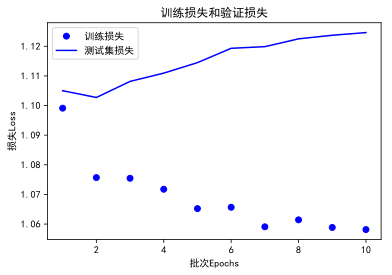

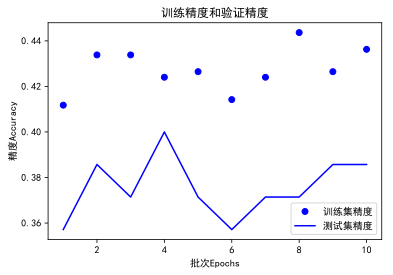

In [350]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False 

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1,len(loss_values)+1)

plt.plot(epochs, loss_values,'bo',label='训练损失') 
plt.plot(epochs, val_loss_values,'b',label='测试集损失') 
plt.title('训练损失和验证损失')
plt.xlabel('批次Epochs')
plt.ylabel('损失Loss')
plt.legend()
plt.show()

acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1,len(acc)+1)

plt.plot(epochs, acc,'bo',label='训练集精度') 
plt.plot(epochs, val_acc,'b',label='测试集精度') 
plt.title('训练精度和验证精度')
plt.xlabel('批次Epochs')
plt.ylabel('精度Accuracy')
plt.legend()
plt.show()

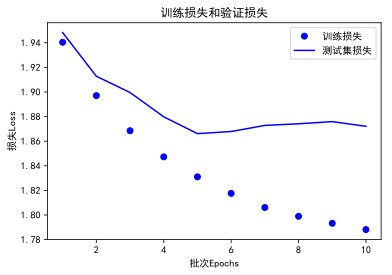

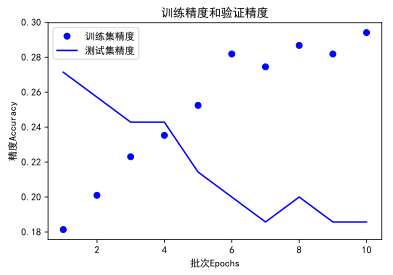

In [323]:
#这个是详细分类标签学习结果
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False 

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1,len(loss_values)+1)

plt.plot(epochs, loss_values,'bo',label='训练损失') 
plt.plot(epochs, val_loss_values,'b',label='测试集损失') 
plt.title('训练损失和验证损失')
plt.xlabel('批次Epochs')
plt.ylabel('损失Loss')
plt.legend()
plt.show()

acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1,len(acc)+1)

plt.plot(epochs, acc,'bo',label='训练集精度') 
plt.plot(epochs, val_acc,'b',label='测试集精度') 
plt.title('训练精度和验证精度')
plt.xlabel('批次Epochs')
plt.ylabel('精度Accuracy')
plt.legend()
plt.show()

In [307]:
#构造RNN使用的数据

train_data = df_final[['name', 'close_val_yesd', 'n_time']].values
train_label = df_final['label'].values

test_data = df_test[['name', 'close_val_yesd', 'n_time']].values
test_label = df_test['label'].values

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
train_data += 10

test_data -= mean
test_data /= std
test_data += 10

one_hot_train_label = to_categorical(train_label)
one_hot_test_label = to_categorical(test_label)

#final_train_label = one_hot_train_label.reshape(one_hot_train_label.shape[1],-1) 
#final_test_label = one_hot_test_label.reshape(one_hot_test_label.shape[1],-1) 


AttributeError: 'float' object has no attribute 'sqrt'

In [339]:
#构造RNN使用的数据

train_data = df_final[['name', 'close_val_yesd', 'n_time']].values
train_label = df_final['label'].values

test_data = df_test[['name', 'close_val_yesd', 'n_time']].values
test_label = df_test['label'].values

mean = train_data.mean()
train_data -= mean
std = train_data.std()
train_data /= std
train_data += 10

test_data -= mean
test_data /= std
test_data += 10

#train_data = train_data.values
#test_data = test_data.values

one_hot_train_label = to_categorical(train_label)
one_hot_test_label = to_categorical(test_label)

train_data

array([[9.182052031916937, 11.294664893678872, 9.652853833733145],
       [9.182052031916937, 11.272736755054988, 9.648188272323807],
       [9.182052031916937, 11.267138081363782, 9.643522710914471],
       ...,
       [9.186391004027621, 11.15236527069409, 9.17696656998076],
       [9.186391004027621, 11.15236527069409, 9.172301008571424],
       [9.186391004027621, 11.157963944385296, 9.167635447162086]],
      dtype=object)

In [341]:
from keras import models
from keras.layers import Dense, SimpleRNN, Embedding, Flatten, LSTM

model = models.Sequential()
model.add(Embedding(len(train_data), 32))
#model.add(SimpleRNN(32))
model.add(LSTM(32))
model.add(Dense(3, activation='softmax'))

model.summary()

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_data, one_hot_train_label,
    epochs = 40,
    batch_size = 32,
    validation_data = (test_data, one_hot_test_label)
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_49 (Embedding)     (None, None, 32)          13056     
_________________________________________________________________
lstm_23 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_248 (Dense)            (None, 3)                 99        
Total params: 21,475
Trainable params: 21,475
Non-trainable params: 0
_________________________________________________________________
Train on 408 samples, validate on 70 samples
Epoch 1/40
408/408 [==============================] - 5s 11ms/step - loss: 1.0948 - acc: 0.3775 - val_loss: 1.1080 - val_acc: 0.3143
Epoch 2/40
408/408 [==============================] - 0s 105us/step - loss: 1.0882 - acc: 0.4191 - val_loss: 1.1140 - val_acc: 0.3143
Epoch 3/40
408/408 [==============================] - 0s 100us/step - loss: 1.0852 - acc: 

In [163]:
o_shape = one_hot_train_label.shape
print('one-hot:',o_shape)
t_shape = train_label.shape
print('original:',t_shape)
f_shape = final_train_label.shape
print('final:',f_shape)

one-hot: (210, 7)
original: (210,)
final: (7, 210)


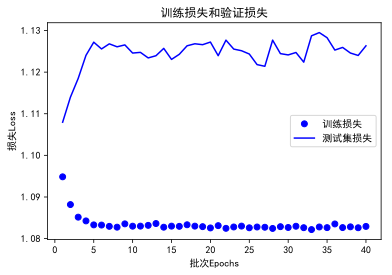

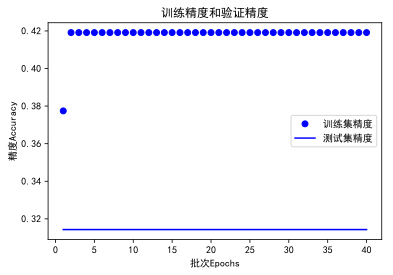

In [342]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False 

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1,len(loss_values)+1)

plt.plot(epochs, loss_values,'bo',label='训练损失') 
plt.plot(epochs, val_loss_values,'b',label='测试集损失') 
plt.title('训练损失和验证损失')
plt.xlabel('批次Epochs')
plt.ylabel('损失Loss')
plt.legend()
plt.show()

acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1,len(acc)+1)

plt.plot(epochs, acc,'bo',label='训练集精度') 
plt.plot(epochs, val_acc,'b',label='测试集精度') 
plt.title('训练精度和验证精度')
plt.xlabel('批次Epochs')
plt.ylabel('精度Accuracy')
plt.legend()
plt.show()